In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_saluki_pmirGLO_construct.npz")
hl, hl_m = np.mean(save_dict['hl'], axis=-1), save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'apadb_count_pooled'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent-resnet',
    'aparent-resnet+hl',
    'aparent',
    'deerect-apa',
    'polyapred',
]

model_scores = [
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_theano_legacy_30_31_34_pasaligned_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_deerect_apa_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted.npy'),
]

use_saluki = [
    False,
    True,
    False,
    False,
    False,
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))


s.shape = (6944, 10)
m.shape = (6944, 10)
l.shape = (6944, 10)
y.shape = (6944, 10)
c.shape = (6944, 10)

hl.shape = (6944, 10)
hl_m.shape = (6944, 10)
a_rich.shape = (6944, 10)


In [3]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]
hl = hl[:, :max_n_pas]
hl_m = hl_m[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

m_cons = (np.sum(m, axis=-1) == np.sum(hl_m, axis=-1))

has_a_rich = np.sum(a_rich, axis=-1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]

m = m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
l = l[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
c = c[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl = hl[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl_m = hl_m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))


m.shape = (5640, 10)
l.shape = (5640, 10)
c.shape = (5640, 10)
y.shape = (5640, 10)
s.shape = (5640, 10)

hl.shape = (5640, 10)
hl_m.shape = (5640, 10)


In [4]:

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


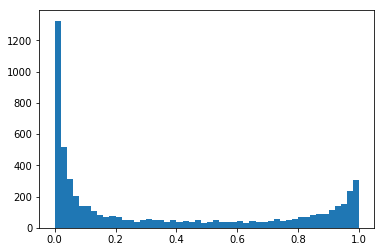

In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [6]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent-resnet'
[ 0.80274949  0.         -0.04521967 -5.1269779   0.85995441  0.
 -0.09039907 -4.7526284 ]
Spearman r = 0.708
AP = 0.8
n = 5640


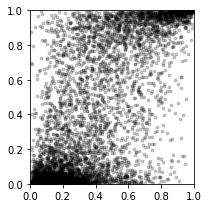

Evaluating model = 'aparent-resnet+hl'
[ 0.76334011 -1.17136825 -0.06773674 -9.74866272  0.835329   -1.37726977
 -0.13207682 -4.90003327]
Spearman r = 0.722
AP = 0.81
n = 5640


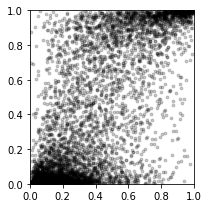

Evaluating model = 'aparent'
[  0.5550394    0.          -0.03814689 -11.41897555   0.51527766
   0.          -0.05391166 -22.7172051 ]
Spearman r = 0.643
AP = 0.75
n = 5640


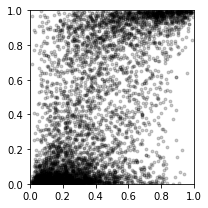

Evaluating model = 'deerect-apa'
[ 3.91268082e-01  0.00000000e+00 -5.87082283e-02 -1.27053606e+01
  6.57791291e-01  0.00000000e+00  5.60640775e-03 -2.78326321e+01]
Spearman r = 0.501
AP = 0.64
n = 5640


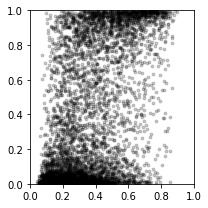

Evaluating model = 'polyapred'
[  0.24711138   0.          -0.06359873 -11.16883317   0.30881594
   0.          -0.04056958 -12.94010418]
Spearman r = 0.446
AP = 0.59
n = 5640


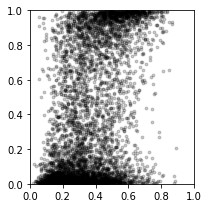

In [7]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + w_prox_hl * hl + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + w_dist_hl * hl + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_hl = w_bundle[1]
    w_prox_len = w_bundle[2]
    w_prox_bias = w_bundle[3]
    w_dist_pas = w_bundle[4]
    w_dist_hl = w_bundle[5]
    w_dist_len = w_bundle[6]
    w_dist_bias = w_bundle[7]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

from sklearn.model_selection import KFold

def cross_val_model(s, hl, m, l, dist_mask, y_true, use_saluki=False, n_folds=10) :
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        s_train, s_test = s[train_index], s[test_index]
        hl_train, hl_test = hl[train_index], hl[test_index]
        m_train, m_test = m[train_index], m[test_index]
        l_train, l_test = l[train_index], l[test_index]
        dist_mask_train, dist_mask_test = dist_mask[train_index], dist_mask[test_index]
        y_true_train = y_true[train_index]
        
        w0 = np.zeros(8)

        res = minimize(logistic_model_mse, w0, args=(s_train, hl_train if use_saluki else 0., m_train, l_train, dist_mask_train, y_true_train), method='BFGS', options={'disp': False})

        w_prox_pas = res.x[0]
        w_prox_hl = res.x[1]
        w_prox_len = res.x[2]
        w_prox_bias = res.x[3]
        w_dist_pas = res.x[4]
        w_dist_hl = res.x[5]
        w_dist_len = res.x[6]
        w_dist_bias = res.x[7]

        if fold_ix == 0 :
            print(res.x)

        y_pred[test_index] = logistic_model_predict(s_test, hl_test if use_saluki else 0., m_test, l_test, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask_test)
    
    return y_pred

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))
model_y_dist_preds = np.zeros((y_dist.shape[0], len(model_scores)))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    y_dist_pred = cross_val_model(s, hl, m, l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap
    model_y_dist_preds[:, model_ix] = y_dist_pred[:]

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [29]:
#Save metrics

np.save("native_apa_multi_apadb_w_saluki_cv_20_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_apadb_w_saluki_cv_20_aps", model_aps)
np.save("native_apa_multi_apadb_w_saluki_cv_20_y_dist_preds", model_y_dist_preds)
np.save("native_apa_multi_apadb_w_saluki_cv_20_orig_l", orig_l)
np.save("native_apa_multi_apadb_w_saluki_cv_20_hl", hl)
np.save("native_apa_multi_apadb_w_saluki_cv_20_y_dist", y_dist)


In [7]:
#Load metrics

model_spearman_rs_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_spearman_rs.npy")
model_aps_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_aps.npy")
model_y_dist_preds_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_y_dist_preds.npy")
model_orig_l_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_orig_l.npy")
model_hl_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_hl.npy")
model_y_dist_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_y_dist.npy")

model_spearman_rs_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_spearman_rs.npy")
model_aps_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_aps.npy")
model_y_dist_preds_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_y_dist_preds.npy")
model_orig_l_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_orig_l.npy")
model_hl_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_hl.npy")
model_y_dist_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_y_dist.npy")

model_spearman_rs_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_spearman_rs.npy")
model_aps_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_aps.npy")
model_y_dist_preds_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_y_dist_preds.npy")
model_orig_l_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_orig_l.npy")
model_hl_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_hl.npy")
model_y_dist_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_y_dist.npy")

model_spearman_rs_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_spearman_rs.npy")
model_aps_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_aps.npy")
model_y_dist_preds_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_y_dist_preds.npy")
model_orig_l_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_orig_l.npy")
model_hl_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_hl.npy")
model_y_dist_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_y_dist.npy")


APADB  Spearman r = [0.708, 0.722, 0.643, 0.501, 0.446]
Leslie Spearman r = [0.671, 0.686, 0.595, 0.481, 0.419]
Derti  Spearman r = [0.601, 0.604, 0.601, 0.371, 0.356]

APADB  Count = 5640
Leslie Count = 5546
Derti  Count = 5442


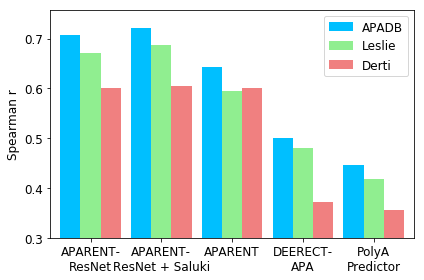

APADB  AP = [0.8, 0.81, 0.75, 0.64, 0.59]
Leslie AP = [0.81, 0.81, 0.75, 0.66, 0.59]
Derti  AP = [0.74, 0.74, 0.73, 0.58, 0.56]


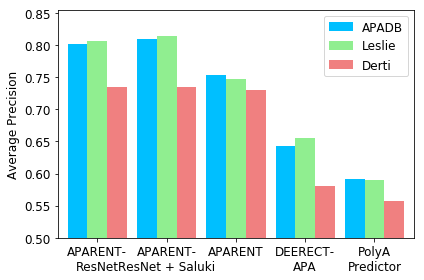

In [9]:

print("APADB  Spearman r = " + str(np.round(model_spearman_rs_apadb, 3).tolist()))
print("Leslie Spearman r = " + str(np.round(model_spearman_rs_leslie, 3).tolist()))
print("Derti  Spearman r = " + str(np.round(model_spearman_rs_derti, 3).tolist()))
print("")

print("APADB  Count = " + str(model_y_dist_apadb.shape[0]))
print("Leslie Count = " + str(model_y_dist_leslie.shape[0]))
print("Derti  Count = " + str(model_y_dist_derti.shape[0]))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 3.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 3.5 + 1, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 3.5 + 2, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 17)
plt.ylim(0.3)

plt.xticks([1, 4.5, 8, 11.5, 15], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_eval_bars_spearman_r.eps")

plt.show()


print("APADB  AP = " + str(np.round(model_aps_apadb, 2).tolist()))
print("Leslie AP = " + str(np.round(model_aps_leslie, 2).tolist()))
print("Derti  AP = " + str(np.round(model_aps_derti, 2).tolist()))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 3.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 3.5 + 1, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 3.5 + 2, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 17)
plt.ylim(0.5)

plt.xticks([1, 4.5, 8, 11.5, 15], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_eval_bars_ap.eps")

plt.show()


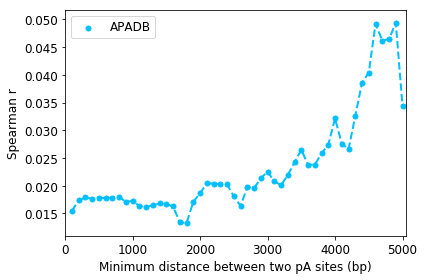

total_n = 5640


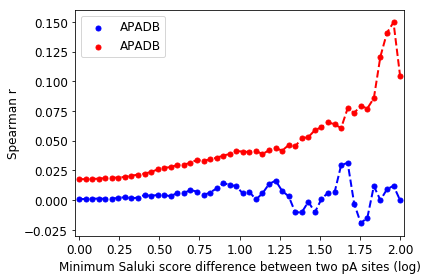

ns_vals_short_isoforms = [790 788 771 745 719 684 641 605 563 512 473 444 411 373 333 309 284 266
 252 235 219 205 189 174 155 142 128 119 110  98  90  83  77  68  63  53
  47  41  39  36  32  31  27  22  20  16  13  11  10   7]
ns_vals_long_isoforms = [4850 4838 4804 4750 4667 4523 4376 4172 3981 3748 3514 3261 3010 2772
 2547 2348 2150 1956 1783 1630 1472 1341 1218 1111 1004  882  773  692
  615  545  483  425  372  329  286  249  215  188  165  136  114   93
   77   70   61   51   35   28   27   23]


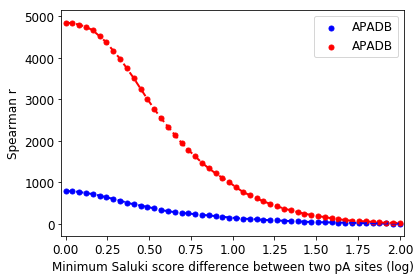

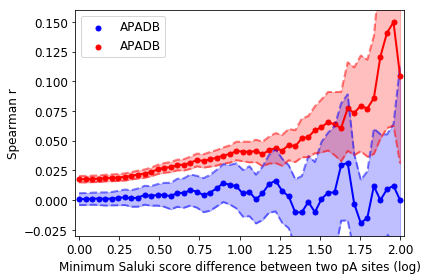

In [45]:
#Analyze improvement of Saluki

model_y_dist_preds = [
    model_y_dist_preds_apadb,
]

model_y_dists = [
    model_y_dist_apadb,
]

model_orig_ls = [
    model_orig_l_apadb,
]

model_hls = [
    model_hl_apadb,
]

data_names = ["APADB"]
data_colors = ["deepskyblue"]

#By minimum distance between two sites

max_l_cutoffs = np.linspace(100, 5000, 50)

f = plt.figure(figsize=(6, 4))

for model_y_dist_pred, y_dist, orig_l, hl, data_name, data_color in zip(model_y_dist_preds, model_y_dists, model_orig_ls, model_hls, data_names, data_colors) :

    y_dist_pred_old = model_y_dist_pred[:, 0]
    y_dist_pred = model_y_dist_pred[:, 1]

    r_vals = []
    for max_l_cutoff in max_l_cutoffs.tolist() :
        keep_index = np.max(orig_l, axis=-1) >= max_l_cutoff

        r_vals.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    r_vals = np.array(r_vals)

    plt.plot(max_l_cutoffs, r_vals, color=data_color, linewidth=2, linestyle='--')
    plt.scatter(max_l_cutoffs, r_vals, s=25, color=data_color, label=data_name)

plt.xlim(0, 5050)
#plt.ylim(0.01, 0.065)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Minimum distance between two pA sites (bp)", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_min_distance_curve.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_min_distance_curve.eps")

plt.show()

#By maximum difference in Saluki score

print("total_n = " + str(model_y_dist_preds[0][:, 0].shape[0]))

isoform_len_cutoff = 250

diff_hl_cutoffs = np.linspace(0., 2.0, 50)

for model_y_dist_pred, y_dist, orig_l, hl, data_name, data_color in zip(model_y_dist_preds, model_y_dists, model_orig_ls, model_hls, data_names, data_colors) :

    y_dist_pred_old = model_y_dist_pred[:, 0]
    y_dist_pred = model_y_dist_pred[:, 1]

    ns_vals_short_isoforms = []
    r_vals_short_isoforms = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)

        ns_vals_short_isoforms.append(np.sum(keep_index))
        r_vals_short_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    ns_vals_short_isoforms = np.array(ns_vals_short_isoforms)
    r_vals_short_isoforms = np.array(r_vals_short_isoforms)
    
    ns_vals_long_isoforms = []
    r_vals_long_isoforms = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)

        ns_vals_long_isoforms.append(np.sum(keep_index))
        r_vals_long_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    ns_vals_long_isoforms = np.array(ns_vals_long_isoforms)
    r_vals_long_isoforms = np.array(r_vals_long_isoforms)

    f = plt.figure(figsize=(6, 4))
    
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms, color='blue', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, r_vals_short_isoforms, s=25, color='blue', label=data_name)
    
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms, color='red', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, r_vals_long_isoforms, s=25, color='red', label=data_name)

    plt.xlim(-0.025, 2.025)
    plt.ylim(-0.025-0.005, 0.16)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
    plt.ylabel("Spearman r", fontsize=12)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("native_apa_multi_w_saluki_cv_20_min_hl_curve_" + data_name + ".png", transparent=True, dpi=300)
    plt.savefig("native_apa_multi_w_saluki_cv_20_min_hl_curve_" + data_name + ".eps")

    plt.show()
    
    print("ns_vals_short_isoforms = " + str(ns_vals_short_isoforms))
    print("ns_vals_long_isoforms = " + str(ns_vals_long_isoforms))
    
    f = plt.figure(figsize=(6, 4))
    
    plt.plot(diff_hl_cutoffs, ns_vals_short_isoforms, color='blue', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, ns_vals_short_isoforms, s=25, color='blue', label=data_name)
    
    plt.plot(diff_hl_cutoffs, ns_vals_long_isoforms, color='red', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, ns_vals_long_isoforms, s=25, color='red', label=data_name)

    plt.xlim(-0.025, 2.025)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
    plt.ylabel("Spearman r", fontsize=12)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("native_apa_multi_w_saluki_cv_20_min_hl_curve_" + data_name + "_count.png", transparent=True, dpi=300)
    plt.savefig("native_apa_multi_w_saluki_cv_20_min_hl_curve_" + data_name + "_count.eps")

    plt.show()

#By maximum difference in Saluki score (bootstrap)

n_bootstrap = 10000

isoform_len_cutoff = 250

diff_hl_cutoffs = np.linspace(0., 2.0, 50)

for model_y_dist_pred, y_dist, orig_l, hl, data_name, data_color in zip(model_y_dist_preds, model_y_dists, model_orig_ls, model_hls, data_names, data_colors) :

    y_dist_pred_old = model_y_dist_pred[:, 0]
    y_dist_pred = model_y_dist_pred[:, 1]

    r_vals_short_isoforms = []
    r_vals_short_isoforms_lower = []
    r_vals_short_isoforms_upper = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)

        r_vals_short_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])
        
        r_vals_short_isoforms_bootstrap = []
        for bootstrap_ix in range(n_bootstrap) :
            sel_index = np.nonzero(keep_index)[0].tolist()
            sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)
            
            r_vals_short_isoforms_bootstrap.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
        
        r_vals_short_isoforms_lower.append(np.quantile(r_vals_short_isoforms_bootstrap, q=0.1))
        r_vals_short_isoforms_upper.append(np.quantile(r_vals_short_isoforms_bootstrap, q=0.9))

    r_vals_short_isoforms = np.array(r_vals_short_isoforms)
    r_vals_short_isoforms_lower = np.array(r_vals_short_isoforms_lower)
    r_vals_short_isoforms_upper = np.array(r_vals_short_isoforms_upper)
    
    r_vals_long_isoforms = []
    r_vals_long_isoforms_lower = []
    r_vals_long_isoforms_upper = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)

        r_vals_long_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])
        
        r_vals_long_isoforms_bootstrap = []
        for bootstrap_ix in range(n_bootstrap) :
            sel_index = np.nonzero(keep_index)[0].tolist()
            sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)
            
            r_vals_long_isoforms_bootstrap.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
        
        r_vals_long_isoforms_lower.append(np.quantile(r_vals_long_isoforms_bootstrap, q=0.1))
        r_vals_long_isoforms_upper.append(np.quantile(r_vals_long_isoforms_bootstrap, q=0.9))

    r_vals_long_isoforms = np.array(r_vals_long_isoforms)
    r_vals_long_isoforms_lower = np.array(r_vals_long_isoforms_lower)
    r_vals_long_isoforms_upper = np.array(r_vals_long_isoforms_upper)

    f = plt.figure(figsize=(6, 4))
    
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_lower, color='blue', alpha=0.5, linewidth=2, linestyle='--')
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms, color='blue', linewidth=2, linestyle='-')
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_upper, color='blue', alpha=0.5, linewidth=2, linestyle='--')
    plt.fill_between(diff_hl_cutoffs, r_vals_short_isoforms_lower, r_vals_short_isoforms_upper, color='blue', alpha=0.25)
    plt.scatter(diff_hl_cutoffs, r_vals_short_isoforms, s=25, color='blue', label=data_name)
    
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_lower, color='red', alpha=0.5, linewidth=2, linestyle='--')
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms, color='red', linewidth=2, linestyle='-')
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_upper, color='red', alpha=0.5, linewidth=2, linestyle='--')
    plt.fill_between(diff_hl_cutoffs, r_vals_long_isoforms_lower, r_vals_long_isoforms_upper, color='red', alpha=0.25)
    plt.scatter(diff_hl_cutoffs, r_vals_long_isoforms, s=25, color='red', label=data_name)

    plt.xlim(-0.025, 2.025)
    plt.ylim(-0.025-0.005, 0.16)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
    plt.ylabel("Spearman r", fontsize=12)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("native_apa_multi_w_saluki_cv_20_min_hl_curve_" + data_name + "_bootstrap.png", transparent=True, dpi=300)
    plt.savefig("native_apa_multi_w_saluki_cv_20_min_hl_curve_" + data_name + "_bootstrap.eps")

    plt.show()


APADB   Spearman r = [0.71, 0.72, 0.64, 0.5, 0.45]
PolyADB Spearman r = [0.68, 0.68, 0.66, 0.54, 0.52]
Leslie  Spearman r = [0.67, 0.69, 0.59, 0.48, 0.42]
Derti   Spearman r = [0.6, 0.6, 0.6, 0.37, 0.36]


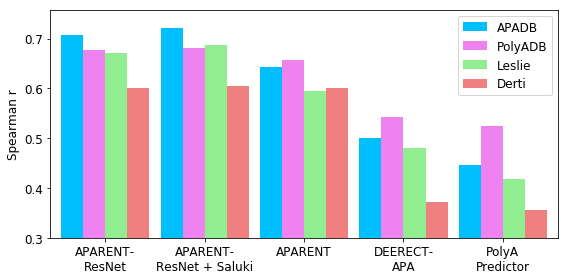

APADB   AP = [0.8, 0.81, 0.75, 0.64, 0.59]
PolyADB AP = [0.76, 0.76, 0.75, 0.61, 0.59]
Leslie  AP = [0.81, 0.81, 0.75, 0.66, 0.59]
Derti   AP = [0.74, 0.74, 0.73, 0.58, 0.56]


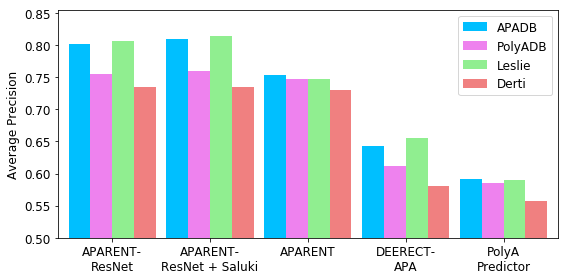

In [9]:

print("APADB   Spearman r = " + str(np.round(model_spearman_rs_apadb, 2).tolist()))
print("PolyADB Spearman r = " + str(np.round(model_spearman_rs_polyadb, 2).tolist()))
print("Leslie  Spearman r = " + str(np.round(model_spearman_rs_leslie, 2).tolist()))
print("Derti   Spearman r = " + str(np.round(model_spearman_rs_derti, 2).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 4.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_polyadb.shape[0]) * 4.5 + 1, model_spearman_rs_polyadb, width=1., edgecolor='black', color='violet', linewidth=0, label='PolyADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 4.5 + 2, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 4.5 + 3, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 22)
plt.ylim(0.3)

plt.xticks([1.5, 6, 10.5, 15, 19.5], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_and_polyadb_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_and_polyadb_eval_bars_spearman_r.eps")

plt.show()


print("APADB   AP = " + str(np.round(model_aps_apadb, 2).tolist()))
print("PolyADB AP = " + str(np.round(model_aps_polyadb, 2).tolist()))
print("Leslie  AP = " + str(np.round(model_aps_leslie, 2).tolist()))
print("Derti   AP = " + str(np.round(model_aps_derti, 2).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 4.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_polyadb.shape[0]) * 4.5 + 1, model_aps_polyadb, width=1., edgecolor='black', color='violet', linewidth=0, label='PolyADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 4.5 + 2, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 4.5 + 3, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 22)
plt.ylim(0.5)

plt.xticks([1.5, 6, 10.5, 15, 19.5], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_and_polyadb_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_and_polyadb_eval_bars_ap.eps")

plt.show()
